In [1]:
#Importing libraries
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, Embedding
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


import tensorflow as tf
import pandas as pd
import tokenize, glob
import os, re, requests, tarfile, shutil, json, glob # For file manipualation only.


In [2]:
%tensorflow_version X.X
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
# Experiment with tokenize library to see its use
with tokenize.open('Data/p00002/Python/s005515634.py') as f:
    tokens = tokenize.generate_tokens(f.readline)
    for token in tokens:
        print(token)

TokenInfo(type=1 (NAME), string='while', start=(1, 0), end=(1, 5), line='while True:\n')
TokenInfo(type=1 (NAME), string='True', start=(1, 6), end=(1, 10), line='while True:\n')
TokenInfo(type=54 (OP), string=':', start=(1, 10), end=(1, 11), line='while True:\n')
TokenInfo(type=4 (NEWLINE), string='\n', start=(1, 11), end=(1, 12), line='while True:\n')
TokenInfo(type=5 (INDENT), string='    ', start=(2, 0), end=(2, 4), line='    try:\n')
TokenInfo(type=1 (NAME), string='try', start=(2, 4), end=(2, 7), line='    try:\n')
TokenInfo(type=54 (OP), string=':', start=(2, 7), end=(2, 8), line='    try:\n')
TokenInfo(type=4 (NEWLINE), string='\n', start=(2, 8), end=(2, 9), line='    try:\n')
TokenInfo(type=5 (INDENT), string='        ', start=(3, 0), end=(3, 8), line='        a, b = map(int, input().split())\n')
TokenInfo(type=1 (NAME), string='a', start=(3, 8), end=(3, 9), line='        a, b = map(int, input().split())\n')
TokenInfo(type=54 (OP), string=',', start=(3, 9), end=(3, 10), line=' 

In [4]:
all_files = glob.glob('data/*/Python/*.py')
print(len(all_files))
np.savetxt('all_py_files.txt', X = all_files, delimiter=',', comments='', fmt='%s')

1600


In [5]:
all_files_mini = glob.glob('data/*/Python/*.py')
np.savetxt('all_py_files.txt', X = all_files_mini, delimiter=',', comments='', fmt='%s')
len(all_files_mini)

1600

In [6]:
def tokenize_and_save(dir_name):
  tokenizerD = Tokenizer(
    num_words=10000,
    filters='',
    lower=False, split=' ', char_level=False, oov_token="<UNK>",
    document_count=0
  )
  
  # Assumes a file with all_py_files.txt name
  file_index = 1
  # with open(dir_name + 'all_py_files.txt') as dir_f:
  #   for py_file in dir_f.readlines():
  for py_file in all_files:
    file_index = file_index + 1
    with tokenize.open(py_file.strip()) as f:
      try:
        tokens = [tok.string for tok in tokenize.generate_tokens(f.readline)]
        tokenizerD.fit_on_texts(tokens)
      except:
        pass 

      if file_index % 2000 == 0:
        print(str(file_index) + " python files tokenized with #tokens: " + str(len(tokenizerD.word_index)))
        tokenizer_json = tokenizerD.to_json()
        with open(dir_name + 'tokenizer.json', 'w') as f:
          json.dump(tokenizer_json, f)

  # Save final version
  tokenizer_json = tokenizerD.to_json()
  with open(dir_name + 'tokenizer.json', 'w') as f:
    json.dump(tokenizer_json, f)

  print('Total tokenizer vocabulary {}'.format(len(tokenizerD.word_index)))


tokenize_and_save('IBM project')

Total tokenizer vocabulary 2091


In [7]:
#Load tokens into 'tokenizer' file. Total tokens created is 213461

path_full = "tokenizer.json"
# path_full = "drive/MyDrive/code_completion_data/samples/tokenizer.json"

with open(path_full) as f:
  json_string = json.load(f)

tokenizer = keras.preprocessing.text.tokenizer_from_json(
    json_string
)
len(tokenizer.word_index)

1048

In [8]:
with open('tokenizer.json') as f:
  json_string = json.load(f)

tokenizer_mini = keras.preprocessing.text.tokenizer_from_json(
    json_string
)

len(tokenizer_mini.word_index)

1048

In [9]:
# files is a list of python files to generate vector on
def vectorize_and_save(files):
  # Load tokenizer
  with open("tokenizer.json") as f:
    json_string = json.load(f)

  tokenizer = keras.preprocessing.text.tokenizer_from_json(
      json_string
  )
  
  seq_length = 10
  header_str = "X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y"
  file_index = 1
  py_file_index = 1
  dataX = []
  n_patterns = 0
  max_rows_in_each_file = 10000000
  for py_file in files:
    with tokenize.open(py_file.strip()) as f:
      try:
        py_file_index = py_file_index + 1
        py_tokens = [tok.string for tok in tokenize.generate_tokens(f.readline)]
        # Now convert the python tokens into an array of tokens from our Corpus tokenizer

        words_tokens = [0]*seq_length + [tokenizer.word_index[w] if w in tokenizer.word_index else tokenizer.word_index['<UNK>'] for w in py_tokens] # Get token id if exists else use <UNK>

        for j in range(len(words_tokens) - seq_length):
          dataX.append(words_tokens[j:j+seq_length+1])

        # Save to file if data reaches max count or if its the last row.
        if len(dataX) >= max_rows_in_each_file:
          file_name = 'dataxy_10_1_{}.csv'.format(file_index)
          np.savetxt(fname = file_name, 
                    X = dataX, 
                    delimiter=',', 
                    comments='',
                    fmt='%d',
                    header=header_str)
          n_patterns = n_patterns + len(dataX)
          dataX = []
          file_index = file_index + 1
          print("Saved to file " + file_name)

        if py_file_index % 2000 == 0:
          print("Processed files {} with dataset size {}".format(py_file_index, n_patterns + len(dataX)))
      except:
        pass 

  # Save once more for left items unsaved
  file_name = 'dataxy_10_1_{}.csv'.format(file_index)
  np.savetxt(fname = file_name, 
            X = dataX, 
            delimiter=',', 
            comments='',
            fmt='%d',
            header=header_str)
  n_patterns = n_patterns + len(dataX)
  
  print("Saved to file " + file_name)

  print ("Total Patterns: ", n_patterns)

In [10]:
py_files = glob.iglob('data/*/Python/*.py')
vectorize_and_save(py_files)

Saved to file dataxy_10_1_1.csv
Total Patterns:  130369


In [11]:
# Now generate on entire dataset full
py_files = glob.iglob('data/*/Python/*.py')
vectorize_and_save(py_files)

Saved to file dataxy_10_1_1.csv
Total Patterns:  130369


In [12]:
dataxy = pd.read_csv('dataxy_10_1_1.csv', header = 0)
display(dataxy)
dataX = dataxy.iloc[:, 0:10].values
dataY = dataxy.iloc[:, 10].values

print(dataX)
print(dataY)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0,0,0,0,0,0,0,0,0,0,27
1,0,0,0,0,0,0,0,0,0,27,5
2,0,0,0,0,0,0,0,0,27,5,45
3,0,0,0,0,0,0,0,27,5,45,3
4,0,0,0,0,0,0,27,5,45,3,1
...,...,...,...,...,...,...,...,...,...,...,...
130364,5,52,3,105,4,2,18,3,50,3,105
130365,52,3,105,4,2,18,3,50,3,105,4
130366,3,105,4,2,18,3,50,3,105,4,4
130367,105,4,2,18,3,50,3,105,4,4,1


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27   5]
 ...
 [  3 105   4 ...   3 105   4]
 [105   4   2 ... 105   4   4]
 [  4   2  18 ...   4   4   1]]
[27  5 45 ...  4  1  1]


In [13]:
tokenizer.word_index

{'<UNK>': 1,
 '\n': 2,
 '(': 3,
 ')': 4,
 '=': 5,
 ':': 6,
 ',': 7,
 '.': 8,
 '1': 9,
 '_': 10,
 'a': 11,
 '"': 12,
 '[': 13,
 ']': 14,
 'x': 15,
 '0': 16,
 'i': 17,
 'print': 18,
 'input': 19,
 '*': 20,
 'y': 21,
 'n': 22,
 'int': 23,
 '2': 24,
 "'": 25,
 'if': 26,
 's': 27,
 'in': 28,
 'for': 29,
 '-': 30,
 'b': 31,
 'w': 32,
 'h': 33,
 'ans': 34,
 '+': 35,
 'split': 36,
 '/': 37,
 'r': 38,
 'else': 39,
 'range': 40,
 'max': 41,
 'map': 42,
 '#': 43,
 '9': 44,
 'list': 45,
 '%': 46,
 '\t': 47,
 'import': 48,
 'math': 49,
 'len': 50,
 'l': 51,
 'str': 52,
 'pi': 53,
 'def': 54,
 'append': 55,
 'and': 56,
 'return': 57,
 'elif': 58,
 'sys': 59,
 '>': 60,
 'c': 61,
 '3': 62,
 '5': 63,
 '{': 64,
 '}': 65,
 'f': 66,
 '!': 67,
 'm': 68,
 'gcd': 69,
 'while': 70,
 '<': 71,
 '6': 72,
 'min': 73,
 'float': 74,
 'num': 75,
 'main': 76,
 'join': 77,
 "''": 78,
 '8': 79,
 'stdin': 80,
 'd': 81,
 'format': 82,
 't': 83,
 'true': 84,
 '?': 85,
 'or': 86,
 'from': 87,
 'replace': 88,
 '4': 89,
 're

In [14]:
#print(dataX.shape)
#print(dataY.shape)
#print(len(np.unique(dataY)))
# Lets build model
#vocab_size_to_predict = len(tokenizer.word_index)+1

#model = Sequential()
#model.add(Embedding(input_dim=vocab_size_to_predict, output_dim=32, mask_zero=True))
#model.add(LSTM(256, input_shape=(dataX.shape[1], 1)))
#model.add(Dropout(0.2))
#model.add(Dense(units = vocab_size_to_predict, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [15]:
## 9. Train and save the best model on Data here
#filepath = "LSTM_model.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
 #                            save_best_only=True, mode='min')
#history = model.fit(dataX, dataY, epochs=20, batch_size=64, callbacks=[checkpoint])

In [16]:
from sklearn.model_selection import train_test_split
X = dataX
y = dataY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)

In [17]:
print(X)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27   5]
 ...
 [  3 105   4 ...   3 105   4]
 [105   4   2 ... 105   4   4]
 [  4   2  18 ...   4   4   1]]


In [18]:
print(len(X))
print(len(y))
print(len(X_train))
print(len(y_train))

130369
130369
87347
87347


In [19]:
print(len(X_test))
print(len(y_test))

43022
43022


In [20]:
print(y)

[27  5 45 ...  4  1  1]


In [21]:
print(dataX)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27   5]
 ...
 [  3 105   4 ...   3 105   4]
 [105   4   2 ... 105   4   4]
 [  4   2  18 ...   4   4   1]]


In [22]:
print(dataY)

[27  5 45 ...  4  1  1]


In [23]:
with open('tokenizer.json') as f:
  json_string = json.load(f)

tokenizer= keras.preprocessing.text.tokenizer_from_json(
    json_string
)

print(len(tokenizer.word_index))
tokenizer.word_index

1048


{'<UNK>': 1,
 '\n': 2,
 '(': 3,
 ')': 4,
 '=': 5,
 ':': 6,
 ',': 7,
 '.': 8,
 '1': 9,
 '_': 10,
 'a': 11,
 '"': 12,
 '[': 13,
 ']': 14,
 'x': 15,
 '0': 16,
 'i': 17,
 'print': 18,
 'input': 19,
 '*': 20,
 'y': 21,
 'n': 22,
 'int': 23,
 '2': 24,
 "'": 25,
 'if': 26,
 's': 27,
 'in': 28,
 'for': 29,
 '-': 30,
 'b': 31,
 'w': 32,
 'h': 33,
 'ans': 34,
 '+': 35,
 'split': 36,
 '/': 37,
 'r': 38,
 'else': 39,
 'range': 40,
 'max': 41,
 'map': 42,
 '#': 43,
 '9': 44,
 'list': 45,
 '%': 46,
 '\t': 47,
 'import': 48,
 'math': 49,
 'len': 50,
 'l': 51,
 'str': 52,
 'pi': 53,
 'def': 54,
 'append': 55,
 'and': 56,
 'return': 57,
 'elif': 58,
 'sys': 59,
 '>': 60,
 'c': 61,
 '3': 62,
 '5': 63,
 '{': 64,
 '}': 65,
 'f': 66,
 '!': 67,
 'm': 68,
 'gcd': 69,
 'while': 70,
 '<': 71,
 '6': 72,
 'min': 73,
 'float': 74,
 'num': 75,
 'main': 76,
 'join': 77,
 "''": 78,
 '8': 79,
 'stdin': 80,
 'd': 81,
 'format': 82,
 't': 83,
 'true': 84,
 '?': 85,
 'or': 86,
 'from': 87,
 'replace': 88,
 '4': 89,
 're

In [24]:
tokenizer.word_docs

{'s': 1299,
 '=': 9746,
 '[': 2443,
 ']': 2443,
 '\n': 15645,
 'a': 2465,
 'int': 1683,
 '(': 12350,
 'input': 2055,
 ')': 12346,
 'if': 1506,
 '0': 2238,
 ':': 4840,
 '.': 3315,
 'append': 360,
 'elif': 343,
 '1': 3004,
 'else': 768,
 'len': 429,
 '>': 309,
 'pop': 100,
 'for': 1222,
 'l': 413,
 'in': 1259,
 'print': 2160,
 'list': 581,
 'map': 679,
 'str': 388,
 ',': 3835,
 'split': 880,
 'ans': 1011,
 'i': 2213,
 '"': 2448,
 'b': 1183,
 'del': 30,
 '-': 1206,
 'join': 210,
 'range': 720,
 "'": 1585,
 "'b'": 105,
 '!': 275,
 'remove': 18,
 "''": 210,
 'is': 28,
 '+': 923,
 'and': 358,
 'while': 267,
 '#': 678,
 'bが存在する間実行': 1,
 'index': 54,
 '最初のbのインデックスを取得': 1,
 'bが先頭でないとき': 1,
 'bの': 1,
 '個前とbを消す': 1,
 'bが先頭の時': 1,
 'この区切り文字でリストを連結': 1,
 '*': 1962,
 'q': 28,
 'chr': 3,
 'x': 2298,
 '8': 178,
 'sep': 19,
 'result': 83,
 'raw': 129,
 '_': 2509,
 'out': 38,
 'import': 546,
 'sys': 320,
 'stdin': 173,
 'ni': 3,
 'lambda': 59,
 'ns': 19,
 'na': 10,
 'readline': 97,
 'or': 145,
 'sentenc

In [25]:
# Above can help with large scale traing but lets focus on one file for now
dataxy = pd.read_csv('dataxy_10_1_1.csv', header = 0)
display(dataxy)
dataX = dataxy.iloc[:, 0:10].values
dataY = dataxy.iloc[:, 10].values

print(dataX)
print(dataY)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0,0,0,0,0,0,0,0,0,0,27
1,0,0,0,0,0,0,0,0,0,27,5
2,0,0,0,0,0,0,0,0,27,5,45
3,0,0,0,0,0,0,0,27,5,45,3
4,0,0,0,0,0,0,27,5,45,3,1
...,...,...,...,...,...,...,...,...,...,...,...
130364,5,52,3,105,4,2,18,3,50,3,105
130365,52,3,105,4,2,18,3,50,3,105,4
130366,3,105,4,2,18,3,50,3,105,4,4
130367,105,4,2,18,3,50,3,105,4,4,1


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27   5]
 ...
 [  3 105   4 ...   3 105   4]
 [105   4   2 ... 105   4   4]
 [  4   2  18 ...   4   4   1]]
[27  5 45 ...  4  1  1]


In [26]:
pip install keras-metrics

Note: you may need to restart the kernel to use updated packages.


In [94]:
#X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state= seed)

In [22]:
import keras_metrics as km

In [29]:
conda install graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/jahnavinp/opt/anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.10.11 |       hecd8cb5_0         125 KB
    cairo-1.16.0               |       h691a603_2         935 KB
    expat-2.4.9                |       he9d5cce_0         127 KB
    font-ttf-dejavu-sans-mono-2.37|       hd3eb1b0_0         335 KB
    font-ttf-inconsolata-2.001 |       hcb22688_0          83 KB
    font-ttf-source-code-pro-2.030|       hd3eb1b0_0         654 KB
    font-ttf-ubuntu-0.83       |       h8b1ccd4_0         1.5 MB
    fontconfig-2.14.1          |       h1659381_0         240 KB
 

(87347, 10)
(87347,)
584


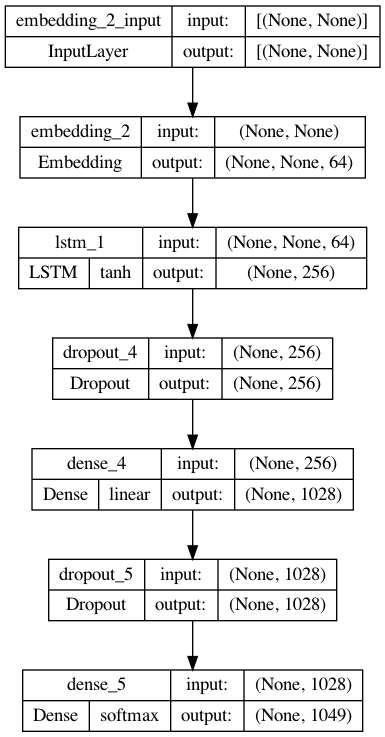

In [53]:
print(X_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))
# Lets build model
vocab_size_to_predict = len(tokenizer.word_index)+1

model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size_to_predict, output_dim=64, mask_zero=True))
model1.add(LSTM(256, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(0.01))
model1.add(Dense(1028))
model1.add(Dropout(0.01))
model1.add(Dense(units = vocab_size_to_predict, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_activations=True)

In [54]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          67136     
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1028)              264196    
                                                                 
 dropout_5 (Dropout)         (None, 1028)              0         
                                                                 
 dense_5 (Dense)             (None, 1049)              1079421   
                                                                 
Total params: 1,739,457
Trainable params: 1,739,457
No

In [55]:
filepath = "LSTM_model_mini.hdf5"
checkpoint1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
history1 = model1.fit(X_train, y_train, epochs=60, batch_size=256, callbacks=[checkpoint1])

Epoch 1/60
341/342 [============================>.] - ETA: 0s - loss: 3.1163 - accuracy: 0.3061
Epoch 1: loss improved from inf to 3.11570, saving model to LSTM_model_mini.hdf5
342/342 [==============================] - 30s 79ms/step - loss: 3.1157 - accuracy: 0.3062
Epoch 2/60
341/342 [============================>.] - ETA: 0s - loss: 1.8617 - accuracy: 0.5527
Epoch 2: loss improved from 3.11570 to 1.86164, saving model to LSTM_model_mini.hdf5
342/342 [==============================] - 26s 77ms/step - loss: 1.8616 - accuracy: 0.5527
Epoch 3/60
341/342 [============================>.] - ETA: 0s - loss: 1.5465 - accuracy: 0.6131
Epoch 3: loss improved from 1.86164 to 1.54636, saving model to LSTM_model_mini.hdf5
342/342 [==============================] - 28s 83ms/step - loss: 1.5464 - accuracy: 0.6131
Epoch 4/60
341/342 [============================>.] - ETA: 0s - loss: 1.3808 - accuracy: 0.6452
Epoch 4: loss improved from 1.54636 to 1.38092, saving model to LSTM_model_mini.hdf5
342/342

Epoch 31/60
341/342 [============================>.] - ETA: 0s - loss: 0.3704 - accuracy: 0.8841
Epoch 31: loss improved from 0.37749 to 0.37036, saving model to LSTM_model_mini.hdf5
342/342 [==============================] - 33s 98ms/step - loss: 0.3704 - accuracy: 0.8841
Epoch 32/60
341/342 [============================>.] - ETA: 0s - loss: 0.3649 - accuracy: 0.8863
Epoch 32: loss improved from 0.37036 to 0.36480, saving model to LSTM_model_mini.hdf5
342/342 [==============================] - 33s 97ms/step - loss: 0.3648 - accuracy: 0.8863
Epoch 33/60
341/342 [============================>.] - ETA: 0s - loss: 0.3592 - accuracy: 0.8874
Epoch 33: loss improved from 0.36480 to 0.35926, saving model to LSTM_model_mini.hdf5
342/342 [==============================] - 33s 98ms/step - loss: 0.3593 - accuracy: 0.8874
Epoch 34/60
341/342 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.8893
Epoch 34: loss improved from 0.35926 to 0.35207, saving model to LSTM_model_mini.

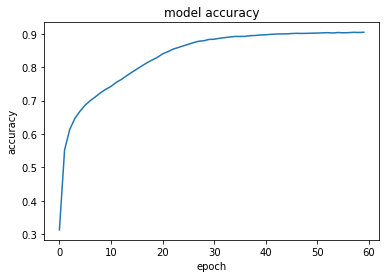

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history1.history['accuracy'])
#plt.plot(history1.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

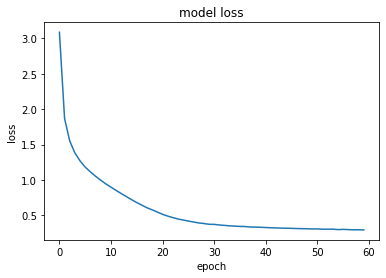

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

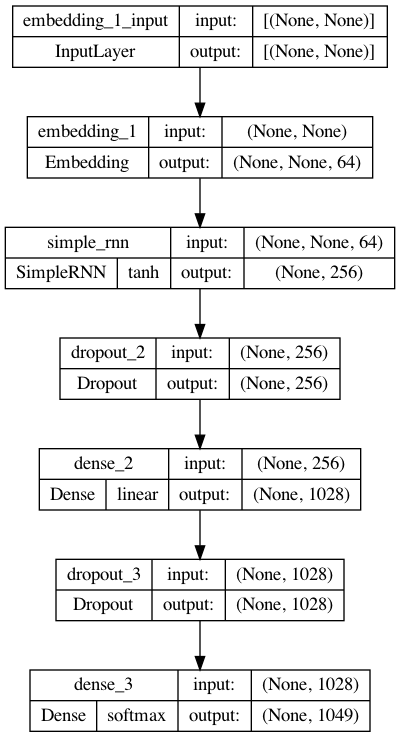

In [29]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size_to_predict, output_dim=64, mask_zero=True))
model2.add(SimpleRNN(256, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.01))
model2.add(Dense(1028))
model2.add(Dropout(0.01))
model2.add(Dense(units = vocab_size_to_predict, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True)

In [74]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [30]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          67136     
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               82176     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1028)              264196    
                                                                 
 dropout_3 (Dropout)         (None, 1028)              0         
                                                                 
 dense_3 (Dense)             (None, 1049)              1079421   
                                                                 
Total params: 1,492,929
Trainable params: 1,492,929
No

In [31]:
filepath = "RNN_model_mini.hdf5"
checkpoint2 = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
history2 = model2.fit(X_train, y_train, epochs=60, batch_size=256,
                      callbacks=[checkpoint2])

Epoch 1/60
341/342 [============================>.] - ETA: 0s - loss: 2.4178 - accuracy: 0.4673
Epoch 1: loss improved from inf to 2.41711, saving model to RNN_model_mini.hdf5
342/342 [==============================] - 13s 37ms/step - loss: 2.4171 - accuracy: 0.4674
Epoch 2/60
341/342 [============================>.] - ETA: 0s - loss: 1.5671 - accuracy: 0.6144
Epoch 2: loss improved from 2.41711 to 1.56730, saving model to RNN_model_mini.hdf5
342/342 [==============================] - 12s 34ms/step - loss: 1.5673 - accuracy: 0.6144
Epoch 3/60
340/342 [============================>.] - ETA: 0s - loss: 1.4247 - accuracy: 0.6361
Epoch 3: loss improved from 1.56730 to 1.42421, saving model to RNN_model_mini.hdf5
342/342 [==============================] - 12s 34ms/step - loss: 1.4242 - accuracy: 0.6362
Epoch 4/60
340/342 [============================>.] - ETA: 0s - loss: 1.3464 - accuracy: 0.6480
Epoch 4: loss improved from 1.42421 to 1.34679, saving model to RNN_model_mini.hdf5
342/342 [==

342/342 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.7380
Epoch 31: loss improved from 0.90861 to 0.90112, saving model to RNN_model_mini.hdf5
342/342 [==============================] - 15s 44ms/step - loss: 0.9011 - accuracy: 0.7380
Epoch 32/60
342/342 [==============================] - ETA: 0s - loss: 0.8905 - accuracy: 0.7415
Epoch 32: loss improved from 0.90112 to 0.89047, saving model to RNN_model_mini.hdf5
342/342 [==============================] - 15s 44ms/step - loss: 0.8905 - accuracy: 0.7415
Epoch 33/60
341/342 [============================>.] - ETA: 0s - loss: 0.8809 - accuracy: 0.7429
Epoch 33: loss improved from 0.89047 to 0.88108, saving model to RNN_model_mini.hdf5
342/342 [==============================] - 15s 44ms/step - loss: 0.8811 - accuracy: 0.7429
Epoch 34/60
342/342 [==============================] - ETA: 0s - loss: 0.8731 - accuracy: 0.7465
Epoch 34: loss improved from 0.88108 to 0.87310, saving model to RNN_model_mini.hdf5
342/342 [==

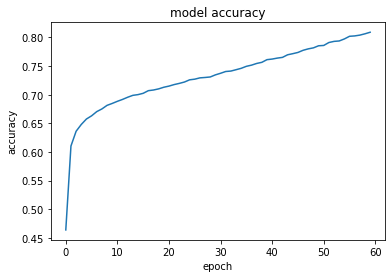

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

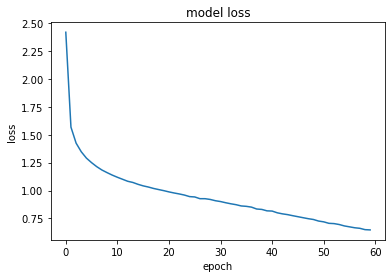

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

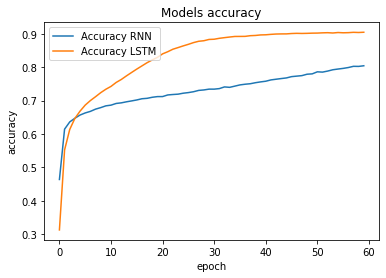

In [52]:
plt.plot(history2.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.title('Models accuracy')
plt.legend(['Accuracy RNN', 'Accuracy LSTM'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [56]:
different = []
for i in range(len(y_p_lstm)):
  if y_p_lstm[i] != y_p_rnn[i]:
    different.append(i)
y_p_lstm[0:10]

[444, 310, 866, 442, 161, 53, 701, 626, 858, 620]

In [35]:
input = []
output_lstm = []
output_rnn = []

for x in X_test:
  input.append([tokenizer.index_word[i] if i in tokenizer.index_word else '' for i in x])

for y in y_p_lstm:
  output_lstm.append(tokenizer.index_word[y] if y in tokenizer.index_word else '')

for y in y_p_rnn:
  output_rnn.append(tokenizer.index_word[y] if y in tokenizer.index_word else '')

In [92]:
model1 = tf.keras.models.load_model("LSTM_model_mini.hdf5")

In [32]:
model2 = keras.models.load_model("RNN_model_mini.hdf5")

In [50]:
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.25)

In [57]:
y_p_lstm = model1.predict(X_test)
y_p_lstm = [np.argmax(y_softmax) for y_softmax in y_p_lstm]

683/683 [==============================] - 6s 8ms/step


In [58]:
print(len(X_test))
print(len(y_test))

21837
21837


In [69]:
print(len(X_test))
print(len(y_test))
print(len(X_val))
print(len(y_val))

21837
21837
65510
65510


In [42]:
y_p_rnn = model2.predict(X_test)
y_p_rnn = [np.argmax(y_softmax) for y_softmax in y_p_rnn]

683/683 [==============================] - 3s 4ms/step


In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print("classfication report:")
print(classification_report(y_test, y_p_rnn))
print("confusion matrix:")
print(confusion_matrix(y_test, y_p_rnn))

classfication report:
              precision    recall  f1-score   support

           1       0.79      0.83      0.81      3586
           2       0.88      0.87      0.87      2712
           3       0.97      0.98      0.97      1957
           4       0.91      0.96      0.93      2001
           5       0.88      0.95      0.91       936
           6       0.94      0.93      0.94       769
           7       0.95      0.86      0.90       611
           8       0.89      0.85      0.87       465
           9       0.79      0.77      0.78       230
          10       0.48      0.87      0.62        15
          11       0.58      0.52      0.55       299
          13       0.83      0.66      0.73       398
          14       0.93      0.92      0.93       420
          15       0.76      0.60      0.67       372
          16       0.71      0.77      0.74       246
          17       0.84      0.77      0.81       353
          18       0.63      0.68      0.65       339
     

/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavin

In [36]:
print("confusion matrix:")
print(confusion_matrix(y_test, y_p_rnn))

confusion matrix:
[[2973  131    9 ...    0    0    0]
 [ 137 2359    0 ...    0    0    0]
 [  15    3 1914 ...    0    0    0]
 ...
 [   0    0    0 ...    1    0    0]
 [   0    0    0 ...    0    1    0]
 [   0    0    0 ...    0    0    1]]


In [37]:
MNB_f1 = round(f1_score(y_test, y_p_rnn, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, y_p_rnn)*100),2)


print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)



Accuracy :  83.15  %
f1_score :  0.831


In [59]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, mean_absolute_error
print("classfication report:")
print(classification_report(y_test, y_p_lstm))

classfication report:
              precision    recall  f1-score   support

           1       0.92      0.93      0.92      3685
           2       0.92      0.94      0.93      2574
           3       1.00      0.99      0.99      2033
           4       0.98      0.96      0.97      2018
           5       0.98      0.93      0.95       945
           6       0.97      0.99      0.98       747
           7       0.96      0.96      0.96       628
           8       0.95      0.94      0.95       491
           9       0.92      0.93      0.92       227
          10       1.00      0.33      0.50        12
          11       0.81      0.80      0.81       271
          13       0.91      0.93      0.92       387
          14       0.98      0.96      0.97       382
          15       0.90      0.91      0.91       372
          16       0.95      0.89      0.92       232
          17       0.88      0.96      0.92       321
          18       0.80      0.79      0.80       340
     

/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavin

In [86]:
print("confusion matrix:")
print(confusion_matrix(y_test, y_p_lstm))

confusion matrix:
[[3420   48    4 ...    0    0    0]
 [  97 2430    0 ...    0    0    0]
 [   3    0 2021 ...    0    0    0]
 ...
 [   0    0    0 ...    1    0    0]
 [   0    0    0 ...    0    1    0]
 [   0    0    0 ...    0    0    1]]


In [60]:
MNB_f1 = round(f1_score(y_test, y_p_lstm, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, y_p_lstm)*100),2)
print("Accuracy : " , MNB_accuracy ,  " %")
print("f1_score : " , MNB_f1)

Accuracy :  91.62  %
f1_score :  0.917


In [31]:
print("Mean Absolute Error:", mean_absolute_error(y_test,y_p_lstm))

Mean Absolute Error: 13.909953047278137


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, mean_absolute_error

In [41]:
print("Mean Absolute Error:", mean_absolute_error(y_test,y_p_rnn))

Mean Absolute Error: 6.815496634153043


In [43]:
y_p_rnn[0:10]

[4, 77, 17, 3, 26, 1, 2, 3, 38, 15]

In [36]:
input[0:10]

[['[', '<UNK>', ',', '<UNK>', ']', '\n', 'n', '=', 'int', '('],
 ['int', ',', 'input', '(', ')', '.', 'split', '(', ')', ')'],
 ['<UNK>', 'while', 'b', '>', '0', ':', '\n', '<UNK>', 'c', '='],
 [')', '\n', '<UNK>', 'else', ':', '\n', '<UNK>', 'a', '[', 't'],
 ['', '', '', '', '', '', '', '', '<UNK>', '\n'],
 ['heappop',
  ',',
  'heappush',
  '\n',
  'sys',
  '.',
  'setrecursionlimit',
  '(',
  '<UNK>',
  '<UNK>'],
 ['\n', 'if', '(', 'r', '<UNK>', '0', ')', ':', '\n', '<UNK>'],
 ['x', '*', '(', '<UNK>', '-', 'y', ')', '\n', '<UNK>', '='],
 ['in', 'input', '(', ')', '.', 'split', '(', '<UNK>', ')', ']'],
 ['append', '(', 'c', ')', '\n', '<UNK>', 'else', ':', '\n', '<UNK>']]

In [37]:
output_rnn[0:10]

['input', ')', 'a', ']', '<UNK>', '9', 'return', '<UNK>', '\n', 'if']

In [38]:
output_lstm[0:10]

['<UNK>', '\n', 'a', ']', '\n', '9', 'print', '<UNK>', '\n', 'if']

In [40]:
input[10:20]

[['\n', 'if', '(', 'b', '[', '0', ']', '<UNK>', 'b', '['],
 ['in', 'n', ':', '\n', '<UNK>', 'if', 'c', '<UNK>', '<UNK>', ':'],
 ['\n', '\n', 'if', 'x', '*', '2', '<UNK>', 'w', 'and', 'y'],
 [':', '\n', '<UNK>', 'if', 'a', '<', 'b', ':', '\n', '<UNK>'],
 ['\n', '<UNK>', 'elif', 's', '[', 'i', ']', '<UNK>', '<UNK>', ':'],
 ['', '', '', '', '', '', '', '', '', 'import'],
 ['z', '=', 'x', '%', 'y', '\n', 'x', '=', 'y', '\n'],
 ['(', '<UNK>', '*', '<UNK>', '/', '2', ',', '0', ')', '\n'],
 ['*', '<UNK>', ',', 'y', '*', '<UNK>', '\n', 'ans', '=', 'max'],
 [':', '-', '1', ']', '\n', '<UNK>', '<UNK>', 'else', ':', '\n']]

In [41]:
output_rnn[10:20]

['0', '\n', '*', 'a', '\n', 'sys', 'y', '<UNK>', '(', '<UNK>']

In [42]:
output_lstm[10:20]

['1', '\n', '*', 'a', '\n', 'sys', 'y', '<UNK>', '(', '<UNK>']

In [43]:
input[20:30]

[['', '', '', '', '', '', '', '', '', ''],
 ['', '', '', '', 'def', 'gcd', '(', 'x', ',', 'y'],
 [')', '\n', '<UNK>', '=', '[', ']', '\n', '\n', 'for', 'i'],
 ['', '', '', '', '', '', 'n', '=', 'int', '('],
 ['=', 'list', '(', 'input', '(', ')', ')', '\n', 'r', '='],
 ['w', '*', '(', 'h', '-', 'y', ')', ')', '\n', '<UNK>'],
 ['', '', '', 'n', '=', 'input', '(', ')', '\n', 's'],
 ['ans', '=', '[', ']', '\n', 'for', 'i', 'in', 'list', ':'],
 ['<UNK>', '0', ':', '\n', '<UNK>', 'return', 'b', '\n', '<UNK>', 'else'],
 ['a', ',', 'b', ')', ',', 'min', '(', 'a', ',', 'b']]

In [44]:
output_rnn[20:30]

['<UNK>', ')', 'in', 'input', "''", 'else', '=', '\n', ':', ')']

In [45]:
output_lstm[20:30]

['<UNK>', ')', 'in', 'input', '[', '<UNK>', '=', '\n', ':', ')']